In [1]:
# Bibliotecas essenciais
import tensorflow as tf
from tensorflow.keras import layers  # Camadas personalizadas
import os  # Manipulação de arquivos
import numpy as np  # Computação numérica
from sklearn.model_selection import train_test_split  # Split balanceado
from sklearn.metrics import classification_report, confusion_matrix  # Avaliação
import seaborn as sns  # Visualização
import matplotlib.pyplot as plt  # Gráficos

# MOTIVAÇÃO:
# - TensorFlow: Framework principal para modelos deep learning
# - Sklearn: Split estratificado (crítico para classes desbalanceadas)
# - Seaborn/Matplotlib: Visualização profissional dos resultados

In [2]:
# Configuração do Kaggle para download
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload do kaggle.json (credenciais)

# Configuração de permissões
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Permissão segura

# Download e unzip do dataset
!kaggle datasets download -d maeloisamignoni/soybeanleafdataset -p /content
!unzip -q /content/soybeanleafdataset.zip -d /content/soybean  # Silencioso

# MOTIVAÇÃO:
# - Comandos do Kaggle necessários para acesso via API
# - Unzip silencioso (-q) evita poluição no output

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/maeloisamignoni/soybeanleafdataset
License(s): unknown
100% 821M/823M [00:07<00:00, 188MB/s]
100% 823M/823M [00:07<00:00, 119MB/s]


In [3]:
data_dir = "/content/soybean/soybean.leaf.dataset"

# Listagem de imagens e labels
image_paths = []
labels = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# MOTIVAÇÃO DO OVERSAMPLING:
# - Original: Healthy ~800 vs outras classes ~3k
# - Objetivo: Reduzir viés do modelo para classes majoritárias
# - Tática: 5x replicação de Healthy (800*5=4000 amostras)
healthy_indices = [i for i, lbl in enumerate(labels) if lbl == 'Healthy']
image_paths += [image_paths[i] for i in healthy_indices] * 4  # +4 cópias = 5x total
labels += ['Healthy'] * (4 * len(healthy_indices))

# Split estratificado (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,  # Mantém proporção das classes
    random_state=42  # Reprodutibilidade
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 10% do total para val e test
    stratify=y_temp,
    random_state=42
)

# MOTIVAÇÃO DO SPLIT:
# - Stratify: Garante representação igual de classes minoritárias
# - 80-10-10: Divisão clássica para datasets médios (~10k amostras)

In [4]:
def create_dataset(image_paths, labels, augment=False, batch_size=32):
    class_names = ['Caterpillar', 'Diabrotica speciosa', 'Healthy']
    label_to_idx = {name: idx for idx, name in enumerate(class_names)}

    # Conversão de labels para índices numéricos
    labels_idx = [label_to_idx[lbl] for lbl in labels]

    # Criação do dataset TensorFlow
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))

    # Função de carregamento de imagens
    def load_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)  # RGB
        image = tf.image.resize(image, (224, 224))  # Tamanho ResNet50
        image = tf.cast(image, tf.float32) / 255.0  # Normalização [0,1]
        return image, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)  # Paralelismo

    # AUGMENTAÇÃO CONDICIONAL (APENAS HEALTHY)
    if augment:
        def augment_image(image, label):
            if label == 2:  # Índice da classe Healthy
                # Transformações agressivas
                image = tf.image.random_flip_left_right(image)  # 50% de chance
                image = tf.image.random_flip_up_down(image)  # 50% de chance
                image = tf.image.random_brightness(image, 0.3)  # ±30% brilho
                image = tf.image.random_contrast(image, 0.5, 1.5)  # Contraste variável
                image = tf.image.random_crop(image, size=[200, 200, 3])  # Crop aleatório
                image = tf.image.resize(image, (224, 224))  # Redimensiona após crop
            return image, label

        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Otimizações de performance
    ds = ds.cache()  # Cache em memória após primeira epoch
    if augment:
        ds = ds.shuffle(1000)  # Shuffle apenas no treino
    ds = ds.batch(batch_size)
    return ds.prefetch(tf.data.AUTOTUNE)  # Pré-carrega batches

# MOTIVAÇÕES TÉCNICAS:
# - Augment apenas em Healthy: Combate overfitting na classe minoritária
# - Crop + resize: Simula diferentes enquadramentos
# - Prefetch: Maximiza utilização da GPU durante treino

In [5]:
train_ds = create_dataset(
    X_train,
    y_train,
    augment=True  # Aplica augmentação apenas no treino
)

val_ds = create_dataset(X_val, y_val)  # Sem augment
test_ds = create_dataset(X_test, y_test)  # Sem augment

# MOTIVAÇÃO:
# - augment=True apenas no treino: Evita vazamento de dados
# - Batch size 32: Balance entre velocidade e generalização

In [6]:
for images, labels in train_ds.take(1):
    print("Shape do batch de imagens:", images.shape)  # (32, 224, 224, 3)
    print("Primeiros labels:", labels.numpy()[:5])
    print("Número de Healthy no batch:", np.sum(labels.numpy() == 2))

# MOTIVAÇÃO:
# - Confirmação visual do pipeline
# - Verificação do balanceamento após oversampling

Shape do batch de imagens: (32, 224, 224, 3)
Primeiros labels: [2 2 0 2 2]
Número de Healthy no batch: 15


In [7]:
from tensorflow.keras.applications import ResNet50

# Base do modelo pré-treinado (Imagenet)
base_model = ResNet50(
    weights='imagenet',  # Pesos pré-treinados
    include_top=False,  # Remove camadas densas finais
    input_shape=(224, 224, 3)  # Tamanho fixo para ResNet
)
base_model.trainable = False  # Congela inicialmente

# Arquitetura customizada
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.8),  # Aumentado de 0.5 para 0.8
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),  # Regularização mais forte
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

# MOTIVAÇÕES:
# - ResNet50: Balance entre performance e complexidade
# - GlobalAveragePooling: Reduz overfitting vs Flatten
# - Dropout 50%: Regularização robusta
# - L2 Regularization: Penaliza pesos grandes

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Cálculo automático de class weights
y_train_idx = [['Caterpillar', 'Diabrotica speciosa', 'Healthy'].index(lbl) for lbl in y_train]
class_counts = np.bincount(y_train_idx)
total = sum(class_counts)
class_weights = {i: total/(len(class_counts)*count) for i, count in enumerate(class_counts)}

# MOTIVAÇÃO CLASS WEIGHTS:
# - Exemplo: Se classe 0 tem 3k amostras e classe 2 tem 4k:
#   weight_classe_0 = (3k+4k+4k)/(3*3k) ≈ 0.96
#   weight_classe_2 = (11k)/(3*4k) ≈ 0.92
# - Penaliza erros nas classes minoritárias

# Focal Loss para sparse labels
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Converte y_true para one-hot (batch_size, 3)
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)

        cross_entropy = -y_true_onehot * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fn

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,  # 10 épocas sem melhora
        restore_best_weights=True  # Mantém melhor modelo
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,  # Reduz LR pela metade
        patience=10,  # Após 10 épocas sem melhora
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True  # Salva apenas o melhor
    )
]

# Compilação Fase 1 (base congelada)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # LR inicial baixo
    loss=focal_loss(),  # Focal Loss customizada
    metrics=['accuracy']
)

# Treinamento Fase 1 (20 épocas)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# FASE 2: FINE-TUNING (descongela 30 camadas)
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Descongela últimas 30 camadas
    layer.trainable = False

# Recompilação com LR menor
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=['accuracy']
)

# Treinamento Fase 2 (mais 40 épocas)
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Total 10+40=50
    initial_epoch=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# MOTIVAÇÕES:
# - Fase 1: Ajuste das camadas densas sem sobre-escrever features da ResNet
# - Fase 2: Fine-tuning de camadas altas da ResNet para especialização
# - LR 1e-6: Ajustes precisos para não corromper pesos bons

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 181ms/step - accuracy: 0.3604 - loss: 3.5036 - val_accuracy: 0.2553 - val_loss: 1.1435 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.3664 - loss: 0.9113 - val_accuracy: 0.3564 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.3830 - loss: 0.3002 - val_accuracy: 0.3393 - val_loss: 0.1558 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.3671 - loss: 0.1658 - val_accuracy: 0.3634 - val_loss: 0.1120 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.3882 - loss: 0.1215 - val_accuracy: 0.3834 - val_loss: 0.0919 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.3981 - loss: 0.0967 - val_accuracy: 0.4484 - val_loss: 0.0788 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/st


Relatório Detalhado:
                     precision    recall  f1-score   support

        Caterpillar     0.4566    0.7946    0.5799       331
Diabrotica speciosa     0.8171    0.6063    0.6961       221
            Healthy     0.7269    0.4219    0.5339       448

           accuracy                         0.5860      1000
          macro avg     0.6669    0.6076    0.6033      1000
       weighted avg     0.6574    0.5860    0.5850      1000



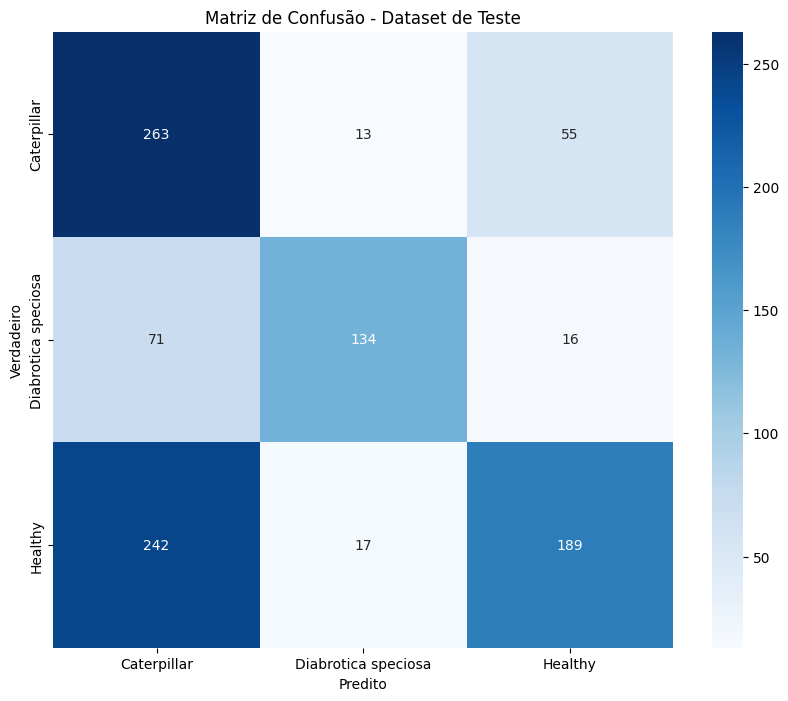

In [9]:
# Coleta de labels e previsões
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images, verbose=0), axis=1))

# Conversão para nomes das classes
class_names = ['Caterpillar', 'Diabrotica speciosa', 'Healthy']
y_true_names = [class_names[idx] for idx in y_true]
y_pred_names = [class_names[idx] for idx in y_pred]

# Relatório de classificação
print("\nRelatório Detalhado:")
print(classification_report(
    y_true_names,
    y_pred_names,
    target_names=class_names,
    digits=4
))

# Matriz de confusão
plt.figure(figsize=(10,8))
sns.heatmap(
    confusion_matrix(y_true_names, y_pred_names),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Dataset de Teste')
plt.show()

# MOTIVAÇÃO:
# - classification_report: Foco em precision/recall por classe
# - Matriz de confusão: Identifica viés entre classes específicas